# BDA Project

Grassi Riccardo

Matr: 1045404

# **About Dataset**

## **Context**
Predict next-day rain by training classification models on the target variable RainTomorrow.

## **Content**
This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

## **Dataset Info**
It consists of   and 23 features (16 categorical and 7 numerical). This dataset contains about 10 years of daily weather observations from many locations across Australia.

## **Task**
The tasks consist of a binary classification problem where in this case the objective is to identify if the next day will rain or not.

# Libraries

In [1]:
!pip install pyspark

In [2]:
# Import other statements
from pyspark.sql.functions import col, avg, when, countDistinct, sum
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [3]:
# Import libraries
import pandas as pd
from pyspark.sql.functions import col, avg, when, countDistinct
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import seaborn as sns

# Spark session

In [4]:
# for cluster mode
"""
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("sparkify").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "5120m").\
        getOrCreate()
"""

'\nfrom pyspark.sql import SparkSession\n\nspark = SparkSession.        builder.        appName("sparkify").        master("spark://spark-master:7077").        config("spark.executor.memory", "5120m").        getOrCreate()\n'

In [5]:
# for local mode
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [6]:
file_csv = 'weatherAUS.csv'

# Load Data

In [7]:
#dataframe for results
final_results = {}
final_results_pd = pd.DataFrame(final_results)

In [8]:
#update Dataframe results
def update_results_df(df_input, model, f1_base, f1_downsampling, f1_upsampling, f1_reweighting):
        res = {
        'Model': [model],
        'F1_Base': [f1_base],
        'F1_Downsampling': [ f1_downsampling],
        'F1_Upsampling': [f1_upsampling],
        'F1_Reweighting':[f1_reweighting],
        }
        res_df = pd.DataFrame(res)
        df_update = pd.concat([df_input, res_df])
        return df_update

In [9]:
# Load the data as the CSV file
dataset = spark.read.csv(file_csv,
                        header = True)

In [10]:
# Print the total number of entries in the CSV file
print('The total number of entries in the CSV file is', dataset.count())

The total number of entries in the CSV file is 145460


In [11]:
# Show the dataset before removing some columns
dataset.show(5, truncate = False)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date      |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|Albury  |13.4   |22.9   |0.6     |NA         |NA      |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |NA      |16.9   |21.8   |No       |No          |
|2008-12-02|

# Fill Null values

In [12]:
#Return a list containing the name of columns to fill
col_name = ['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']


In [13]:
# Create a function that counts the null values in each column from the dataset
def count_null_values(col_name):
    return dataset.where(col(col_name) == 'NA').count()

In [14]:
# Print the number of null values in each column from the dataset
for column in col_name:
    print('The number of null values in {0}: {1}'.format(column, count_null_values(column)))

The number of null values in MinTemp: 1485
The number of null values in MaxTemp: 1261
The number of null values in Rainfall: 3261
The number of null values in WindGustSpeed: 10263
The number of null values in WindDir9am: 10566
The number of null values in WindDir3pm: 4228
The number of null values in WindSpeed9am: 1767
The number of null values in WindSpeed3pm: 3062
The number of null values in Humidity9am: 2654
The number of null values in Humidity3pm: 4507
The number of null values in Pressure9am: 15065
The number of null values in Pressure3pm: 15028
The number of null values in RainToday: 3261
The number of null values in RainTomorrow: 3267


In [15]:
# Check the type of value in the dataset
dataset.dtypes

[('Date', 'string'),
 ('Location', 'string'),
 ('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('Evaporation', 'string'),
 ('Sunshine', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('Cloud9am', 'string'),
 ('Cloud3pm', 'string'),
 ('Temp9am', 'string'),
 ('Temp3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [16]:
# Show the dataset
dataset.show(5)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|          No|
|2008-12-02|

# Null values in numerical cols

There are two types of data values in this dataset which are numeric and non numeric values. For this step, I am obtaining the average of the columns which consist of numeric values individually and replacing the NA values with the average value of that column. For the non numeric values, I am obtaining the most frequent item of the column and replace the NA values with the most frequent item of that column.

In [17]:
# Create a list that contains the name of columns having numeric values
num_col = ['MinTemp',
          'MaxTemp',
          'Rainfall',
          'WindGustSpeed',
          'WindSpeed9am',
          'WindSpeed3pm',
          'Humidity9am',
          'Humidity3pm',
          'Pressure9am',
          'Pressure3pm']

In [18]:
# Create a function that calculates the average value of numeric columns
def calculate_avg_val(col_name):
    avg_val = dataset.agg(avg(col(col_name))).collect()[0][0]
    return avg_val

In [19]:
# Fill null values in each numeric columns by the average value
for col_name in num_col:
    dataset = dataset.withColumn(col_name, \
                                 when(dataset[col_name] == 'NA',\
                                      calculate_avg_val(col_name)).otherwise(dataset[col_name]))

In [20]:
# Show the dataset after filling null values
dataset.show(truncate = False)

+----------+--------+-------+-------+------------------+-----------+--------+-----------+-----------------+----------+----------+------------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date      |Location|MinTemp|MaxTemp|Rainfall          |Evaporation|Sunshine|WindGustDir|WindGustSpeed    |WindDir9am|WindDir3pm|WindSpeed9am      |WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+------------------+-----------+--------+-----------+-----------------+----------+----------+------------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|Albury  |13.4   |22.9   |0.6               |NA         |NA      |W          |44               |W         |WNW       |20                |24          |71         |22         |1007.7     |10

# Null values in categorical cols

In [21]:
# Create a list that contains the name of columns having non_numeric values
non_num_col = ['WindDir9am',
              'WindDir3pm',
              'RainToday',
              'RainTomorrow']

In [22]:
def calculate_freq_val(col_name):
    order_data = dataset.groupBy(col_name).count()
    most_freq_val = order_data.select(col_name).where(col('count') == \
                                                       order_data.sort(col('count').desc()).\
                                                       select('count').collect()[0][0]).collect()[0][0]
    return most_freq_val

In [23]:
# Fill null values in each non-numeric columns by the most frequent value
for col_name in non_num_col:
    dataset = dataset.withColumn(col_name, \
                                 when(dataset[col_name] == 'NA',\
                                      calculate_freq_val(col_name)).otherwise(dataset[col_name]))

# EDA

### Which location received the highest Rainfall ?

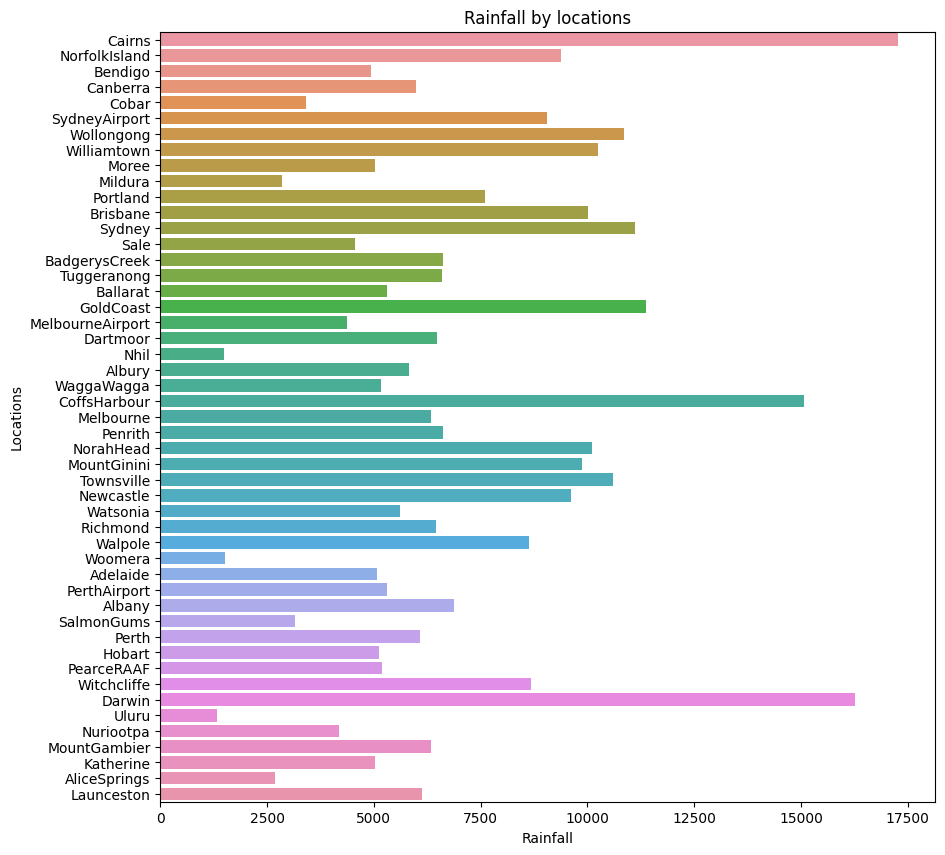

In [24]:
# converte il DataFrame Spark in un DataFrame Pandas
df_location = dataset.groupby("Location").agg(sum("Rainfall")).toPandas()

# crea il grafico a barre utilizzando Seaborn
plt.figure(figsize=(10, 10))
sns.barplot(x='sum(Rainfall)' ,y="Location", data=df_location)

plt.title('Rainfall by locations')
plt.xlabel('Rainfall', fontsize=10)
plt.ylabel('Locations', fontsize=10)
plt.show()


### Which year received the highest rainfall ?

Since the dates are written in a compact manner, I preprocessed the dates to obtain the desired formats in order to print the graphs appropriately

In [25]:
df_date = dataset.select("Date", "Rainfall").toPandas()
df_date

,Date,Rainfall
0,2008-12-01,0.6
1,2008-12-02,0
2,2008-12-03,0
3,2008-12-04,0
4,2008-12-05,1
...,...,...
145455,2017-06-21,0
145456,2017-06-22,0
145457,2017-06-23,0
145458,2017-06-24,0


In [26]:
# Convert date column to datetime
df_date['Date']= pd.to_datetime(df_date['Date'])

In [27]:
# Creating new cols from date
df_date['Year'] = df_date['Date'].dt.year
df_date['Month'] = df_date['Date'].dt.month
df_date['Week'] = df_date['Date'].dt.weekday
df_date['Day'] = df_date['Date'].dt.day

# Drop date columns
df_date.drop('Date', axis=1, inplace=True)

In [28]:
#cast values
df_date['Year'] = df_date['Year'].astype(int)
df_date['Rainfall'] = df_date['Rainfall'].astype(float)
df_date

,Rainfall,Year,Month,Week,Day
0,0.6,2008,12,0,1
1,0.0,2008,12,1,2
2,0.0,2008,12,2,3
3,0.0,2008,12,3,4
4,1.0,2008,12,4,5
...,...,...,...,...,...
145455,0.0,2017,6,2,21
145456,0.0,2017,6,3,22
145457,0.0,2017,6,4,23
145458,0.0,2017,6,5,24


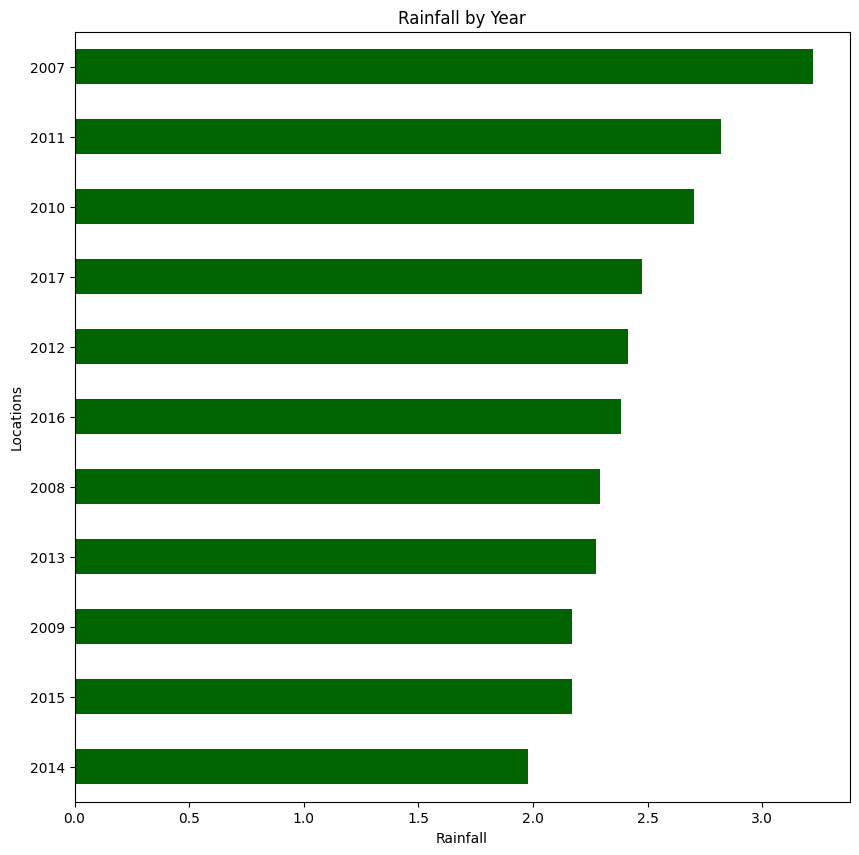

In [29]:
#plot rainfall by year
plt.figure(figsize=(10, 10))

location_rain = df_date.groupby('Year')['Rainfall'].mean().sort_values().plot(kind='barh', color= 'darkgreen')

plt.title('Rainfall by Year')
plt.xlabel('Rainfall', fontsize=10)
plt.ylabel('Locations', fontsize=10)
plt.show()

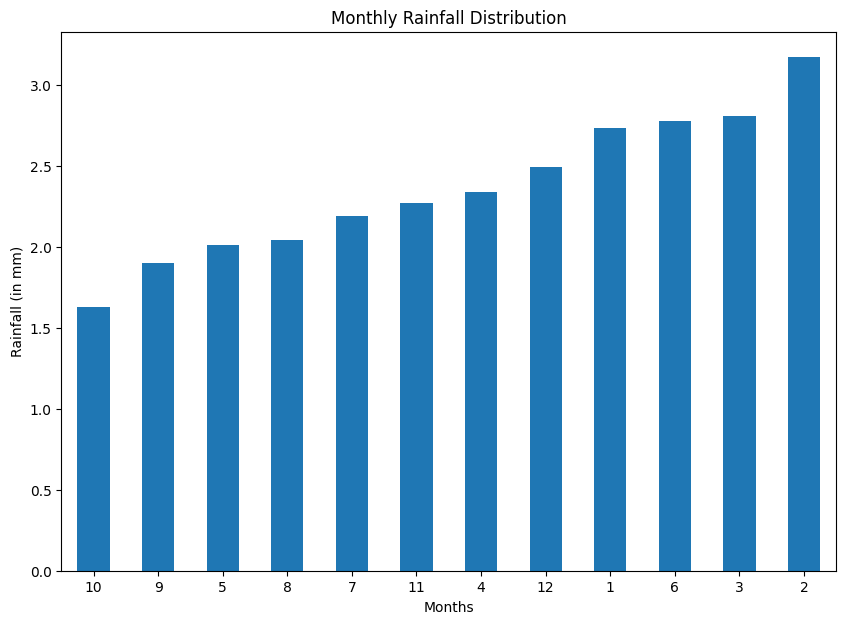

In [30]:
plt.figure(figsize=(10,7))

df_date.groupby('Month')['Rainfall'].mean().sort_values().plot(kind='bar')

plt.title('Monthly Rainfall Distribution', fontsize=12)
plt.xlabel('Months')
plt.ylabel('Rainfall (in mm)')

plt.xticks(rotation=0)

plt.show()

## Rain today

In [31]:
df_rain_today = dataset.groupby(['RainToday']).count()
df_rain_today.show()

+---------+------+
|RainToday| count|
+---------+------+
|       No|113580|
|      Yes| 31880|
+---------+------+



<Axes: xlabel='RainToday', ylabel='count'>

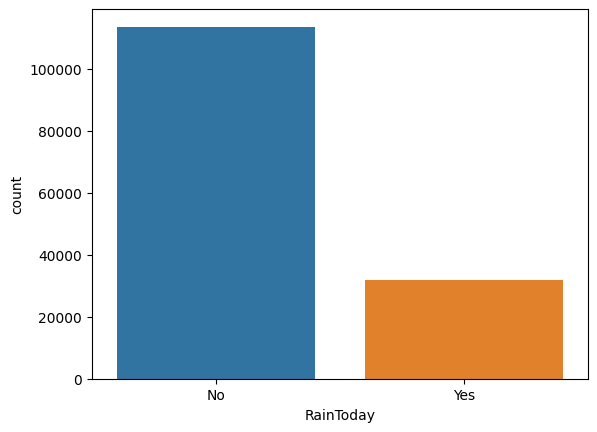

In [32]:
df_rain_today = df_rain_today.toPandas()
sns.barplot(x='RainToday', y='count', data= df_rain_today)

# Feature Selection

Some useless columns have been deleted in order to make the model more simple e performing.

In [33]:
## Delete 'Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm' column from the dataset
dataset = dataset.select([column for column in dataset.columns if column not in {'Date', 'Location', 'Evaporation', 'WindGustDir','Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'}])


In [34]:
# Show the dataset after removing some columns
dataset.show(5)

+-------+-------+--------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|     1008.7|       No|          No|
|    9.2|     28|       0|           24|

# Transform numerical data

Data transformation is done so that it will be useful to process by the machine learning algorithm. Numerical value columns are firstly transformed by type casting them to double as they are defined as string. Then, the non numerical value column are converted to numbers using stringindexer.

In [35]:
# Convert values of numeric columns from the 'string' type into the 'double' type
for col_name in num_col:
    dataset = dataset.withColumn(col_name, col(col_name).cast('double'))

# Transform non-numerical data

In PySpark, the **StringIndexer** is a method or transformer used for converting categorical or string features into numerical indices. It assigns a unique index to each distinct string value in a column, effectively encoding categorical variables as numerical representations. This numerical representation is often required by machine learning algorithms that expect numerical input.

In [36]:
# Create a list of index for each value of each non-numerical column
indexers = [StringIndexer(inputCol = col_name,
                         outputCol = col_name + '_index').\
            fit(dataset) for col_name in non_num_col]

In [37]:
# Create a Pipeline consisting of a sequence of stages which are indexs created from the list above
pipeline = Pipeline(stages = indexers)

In [38]:
# The fitted model from the Pipeline which consists of fitted models and transformers, corresponding to the pipeline stages
# The Transformer implements the method transform() which converts the dataframe into another,
# by appending index columns predicted from the 'fit' model
dataset = pipeline.fit(dataset).transform(dataset)

In [39]:
# Drop non-numerical columns in the dataset
dataset = dataset.drop('WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow')

In [40]:
# Show the dataset after transforming non-numerical data
dataset.show(5)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|             6.0|             7.0|            0.0|               0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|             9.0|             3.0|            0.0|               0.0|
|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|  

## Feature distribution

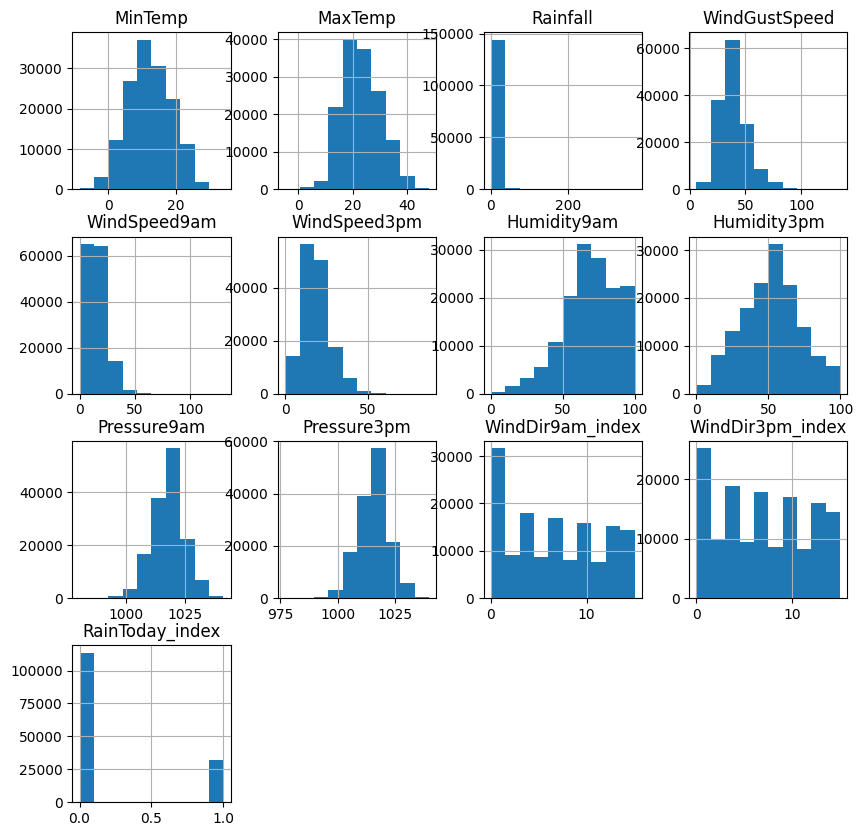

In [41]:
# Inspect aggregated data
pandas_df = dataset.toPandas()
hist = pandas_df.drop("RainTomorrow_index", axis= 1).hist(figsize = (10,10))

## Target distribution

In [42]:
def get_class_distribution(df_input, col):
    ax = sns.countplot(x= col, hue='RainTomorrow_index', data=df_input, dodge = False)

    #print text above each column
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2,
                p.get_height() + 0.005 * ax.get_ylim()[1],
                '{:.0f}'.format(p.get_height()),
                ha='center')
    plt.show()

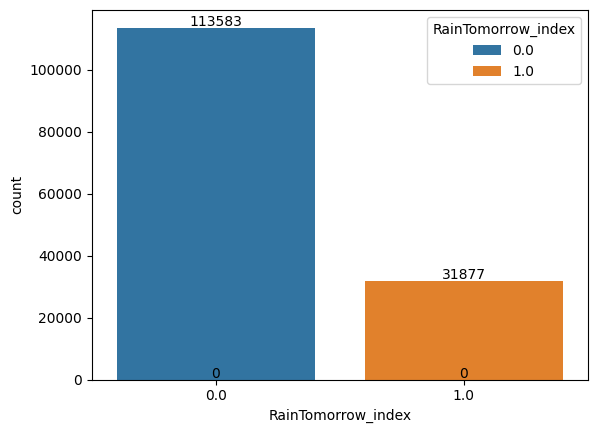

In [43]:
get_class_distribution(pandas_df, "RainTomorrow_index")

## Correlation among features

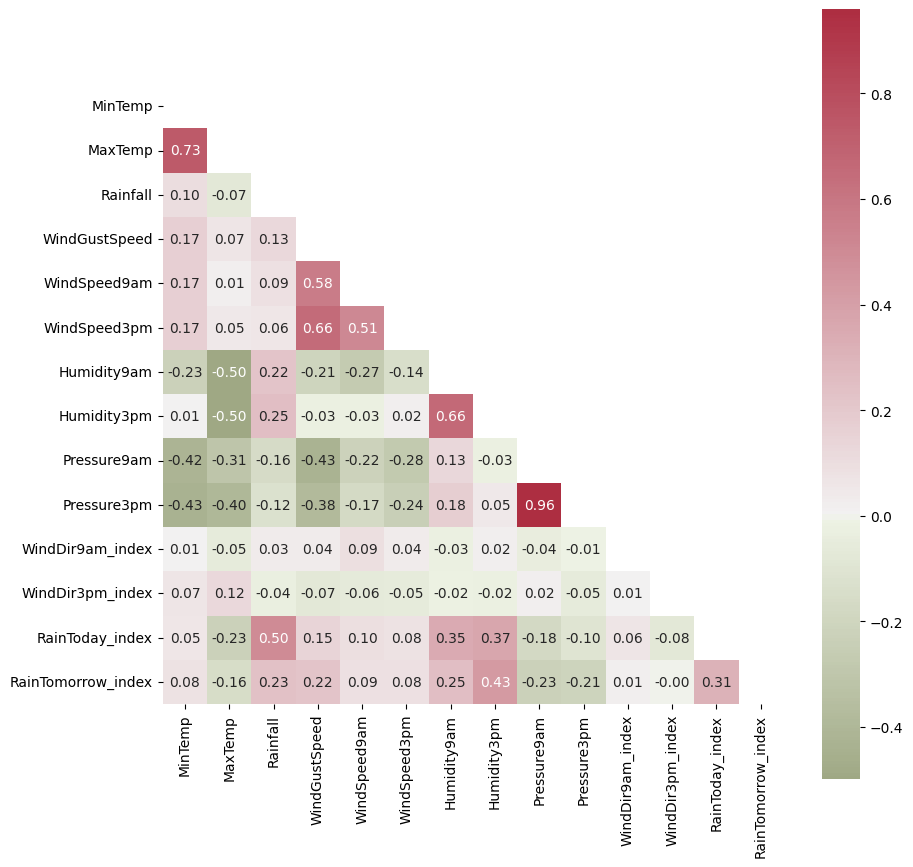

In [44]:
# Get correlations

# Calculate pairwise-correlation
matrix = pandas_df.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.show();

# Create feature vector

For this step, I am creating feature vector with the columns in the dataset. To create the feature vector,I have excluded the column (categoryRainTomorrow) that I will be using for testing the accuracy of my model. After that a standard scaler has been applied.

 It transforms the data in a way that each feature has a mean of zero and a standard deviation of one.

 Overall, using StandardScaler as a preprocessing step can help improve the performance, stability, and interpretability of machine learning models, particularly when dealing with features that have different scales or require normality assumptions.

In [45]:
dataset.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustSpeed', 'double'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('WindDir9am_index', 'double'),
 ('WindDir3pm_index', 'double'),
 ('RainToday_index', 'double'),
 ('RainTomorrow_index', 'double')]

In [46]:
# Create a Transformer that combines a given list of columns into a single vector column
# except 'RainTomorrow_index' column
assembler = VectorAssembler(
inputCols = list(set(dataset.columns) - set(['RainTomorrow_index'])),
outputCol = 'FeatureVector')

In [47]:
# Standard Scaler
standardscaler = StandardScaler(inputCol='FeatureVector', outputCol="features", withMean=True, withStd=True)

In [48]:
# Return the new dataset by adding the feature vector column
dataset = assembler.transform(dataset)

In [49]:
dataset.columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'WindDir9am_index',
 'WindDir3pm_index',
 'RainToday_index',
 'RainTomorrow_index',
 'FeatureVector']

In [50]:
# Show the dataset that contains only two columns including 'RainTomorrow_index' and 'FeatureVector'
new_df = dataset.select(*('RainTomorrow_index', 'FeatureVector'))
new_df.show(5)

+------------------+--------------------+
|RainTomorrow_index|       FeatureVector|
+------------------+--------------------+
|               0.0|[22.0,6.0,0.0,71....|
|               0.0|[25.0,9.0,0.0,44....|
|               0.0|[30.0,6.0,0.0,38....|
|               0.0|[16.0,1.0,0.0,45....|
|               0.0|[33.0,10.0,0.0,82...|
+------------------+--------------------+
only showing top 5 rows



# Split the dataset

The dataset has been splitten in 70% train set and 30% test set.

In [51]:
# Split the dataset randomly between 70% and 30%
(trainingData, testData) = new_df.randomSplit([0.7, 0.3],seed=42)

The 2 plots below highlight that the classes in train and test set are imbalanced.

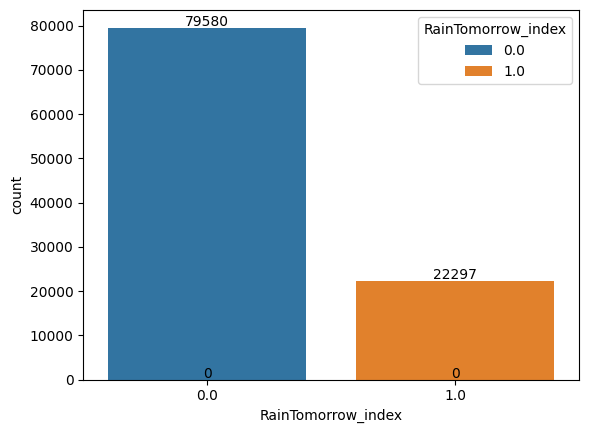

In [52]:
get_class_distribution(trainingData.toPandas(), "RainTomorrow_index")

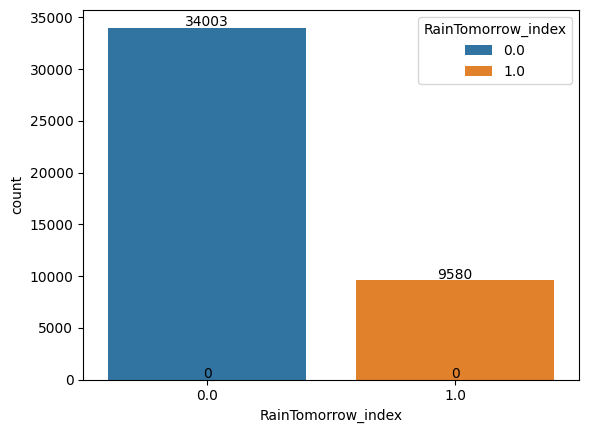

In [53]:
get_class_distribution(testData.toPandas(), "RainTomorrow_index")

## Calculate Measures (Precision, Recall, F1) for each classifier and Confusion matrix


In binary classification, the F1 score is often considered alongside accuracy as a metric because accuracy alone can be misleading in the presence of imbalanced classes.

The F1 score combines precision and recall into a single metric that balances both aspects. It is the harmonic mean of precision and recall and provides a more balanced evaluation of the classifier's performance, especially in scenarios with imbalanced classes. The F1 score reaches its highest value at 1 and its lowest at 0, with higher values indicating better performance.

In [54]:
# Build the function to calculate the precision, recall and F1 score from the confusion matrix
def calculate_rates(confusion_matrix):
    def calculate_precision(confusion_matrix):
        return confusion_matrix[1][1]/(confusion_matrix[1][0] + confusion_matrix[1][1])
    def calculate_recall(confusion_matrix):
        return confusion_matrix[1][1]/(confusion_matrix[0][1] + confusion_matrix[1][1])
    def calculate_f1_score(confusion_matrix):
        return (2*calculate_precision(confusion_matrix)*calculate_recall(confusion_matrix))/\
    (calculate_precision(confusion_matrix) + calculate_recall(confusion_matrix))
    return calculate_precision(confusion_matrix), calculate_recall(confusion_matrix), calculate_f1_score(confusion_matrix)

In [55]:
# The list of rates
rates = ['Precision', 'Recall', 'F1 Score']

In [56]:
def get_confusion_matrix(predictions):
    # Create the confusion matrix including actual values and predicted values of RainTomorrow_index of Decision Tree Classifier
    sub_predictions = predictions.select(['RainTomorrow_index', 'prediction'])
    sub_predictions = sub_predictions.rdd.map(tuple)
    metrics = MulticlassMetrics(sub_predictions)
    confusion_mat = metrics.confusionMatrix()
    confusion_mat = confusion_mat.toArray()
    return confusion_mat

# Apply ML algorithm

For this step, 4 machine learning classfication algorithms consisting of Decision tree, random forest, logistic regression and gradient boosting were used and their results are compared.

In [57]:
# Calculate the accuracy of the prediction
evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
                                              predictionCol='prediction',\
                                              metricName="accuracy")

In [58]:
def fit_model(model, train, test, paramGrid = None):
    pipeline = Pipeline(stages=[standardscaler, model])

    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator= evaluator,
                          numFolds=3)
        model = crossval.fit(train)
    else:
        model = pipeline.fit(train)


    predictions = model.transform(test)
    return model, predictions


In [59]:
def fit_model_train(model, train, test, paramGrid = None):
    pipeline = Pipeline(stages=[standardscaler, model])

    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator= evaluator,
                          numFolds=3)
        model = crossval.fit(train)
    else:
        model = pipeline.fit(train)


    predictions = model.transform(train)
    return model, predictions

## Decision Tree

In [60]:
# Predict the values of RainTomorrow_index by the Decision Tree Classifier model
dt = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="FeatureVector")

# Creazione della paramGrid
param_grid_dt = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [8,10,11])
              .addGrid(dt.maxBins, [120,128,135,])
              .addGrid(dt.minInstancesPerNode, [95,100,105])
              .build())

In [61]:
dtModel, dt_predictions = fit_model(dt,trainingData,testData)

In [62]:
dt_confusion_mat = get_confusion_matrix(dt_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
print("The accuracy of the Decision Tree Classifier is %g " % (dt_accuracy))
_, _, dt_f1  =  calculate_rates(dt_confusion_mat)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(dt_confusion_mat)[i]))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The accuracy of the Decision Tree Classifier is 0.836037 
The Precision of the Decision Tree Classifier is 0.7201519536903039
The Recall of the Decision Tree Classifier is 0.41555323590814197
The F1 Score of the Decision Tree Classifier is 0.5270055599682287


In [63]:
_, dt_predictions_train = fit_model_train(dt,trainingData,testData)

In [64]:
dt_confusion_mat = get_confusion_matrix(dt_predictions_train)
_, _, dt_f1_train  =  calculate_rates(dt_confusion_mat)
# Calculate the rates from the confusion matrix
print("Train Set F1:", dt_f1_train )

Train Set F1: 0.5315665522231365


## Random Forest


In [65]:
# Predict the values of RainTomorrow_index by the Random Forest Classifier model
rf = RandomForestClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", numTrees=10)

# Creazione della paramGrid
param_grid_rf= (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5,10,15])
             .addGrid(rf.numTrees, [10,15,20])
             .build())

In [66]:
rfModel, rf_predictions = fit_model(rf,trainingData,testData)

In [67]:
rf_confusion_mat = get_confusion_matrix(rf_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)
print("The accuracy of the Decision Tree Classifier is %g " % (rf_accuracy))
_, _, rf_f1  =  calculate_rates(rf_confusion_mat)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(rf_confusion_mat)[i]))

The accuracy of the Decision Tree Classifier is 0.83567 
The Precision of the Decision Tree Classifier is 0.7662995594713656
The Recall of the Decision Tree Classifier is 0.36315240083507305
The F1 Score of the Decision Tree Classifier is 0.4927762039660056


In [68]:
_, rf_predictions_train = fit_model_train(rf,trainingData,testData)

In [69]:
rf_confusion_mat = get_confusion_matrix(rf_predictions_train)
_, _, dt_f1_train  =  calculate_rates(rf_confusion_mat)
# Calculate the rates from the confusion matrix
print("Train Set F1:", dt_f1_train )

Train Set F1: 0.49320400158117184


## Logistic Regression

In [70]:
# Predict the values of RainTomorrow_index by the Logistic Regression model
lr = LogisticRegression(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10)

# Creazione della paramGrid
param_grid_lr= (ParamGridBuilder()
             .addGrid(lr.maxIter, [5, 10, 20])
             .addGrid(lr.regParam, [0.01, 0.1, 1.0])
             .addGrid(lr.elasticNetParam, [0.01,0.001 ])
             .build())

In [71]:
lrModel, lr_predictions = fit_model(lr,trainingData,testData)

In [72]:
lr_confusion_mat = get_confusion_matrix(lr_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)
print("The accuracy of the Decision Tree Classifier is %g " % (lr_accuracy))
_, _, lr_f1  =  calculate_rates(lr_confusion_mat)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(lr_confusion_mat)[i]))

The accuracy of the Decision Tree Classifier is 0.83918 
The Precision of the Decision Tree Classifier is 0.7096037828142834
The Recall of the Decision Tree Classifier is 0.4542797494780793
The F1 Score of the Decision Tree Classifier is 0.5539362311461846


In [73]:
_, lr_predictions_train = fit_model_train(lr,trainingData,testData)

In [74]:
lr_confusion_mat = get_confusion_matrix(lr_predictions_train)
_, _, lr_f1_train  =  calculate_rates(lr_confusion_mat)
# Calculate the rates from the confusion matrix
print("Train Set F1:", lr_f1_train )

Train Set F1: 0.5600737367165475


## GBT Classifier

In [75]:
# Predict the values of RainTomorrow_index by the GBT Classifier model
#set maxiter 30
gbt = GBTClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10)

# Creazione della paramGrid
param_grid_gbt= (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5,7,10])
             .build())

In [76]:
gbtModel, gbt_predictions = fit_model(gbt,trainingData,testData)

In [77]:
gbt_confusion_mat = get_confusion_matrix(gbt_predictions)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("The accuracy of the Decision Tree Classifier is %g " % (gbt_accuracy))
_, _, gbt_f1  =  calculate_rates(gbt_confusion_mat)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(gbt_confusion_mat)[i]))

The accuracy of the Decision Tree Classifier is 0.841819 
The Precision of the Decision Tree Classifier is 0.7367771509167842
The Recall of the Decision Tree Classifier is 0.4362212943632568
The F1 Score of the Decision Tree Classifier is 0.547993705743509


In [78]:
_, gbt_predictions_train = fit_model_train(gbt,trainingData,testData)

In [79]:
gbt_confusion_mat = get_confusion_matrix(gbt_predictions_train)
_, _, gbt_f1_train  =  calculate_rates(gbt_confusion_mat)
# Calculate the rates from the confusion matrix
print("Train Set F1:", gbt_f1_train )

Train Set F1: 0.5545793920341315


## Plot of results

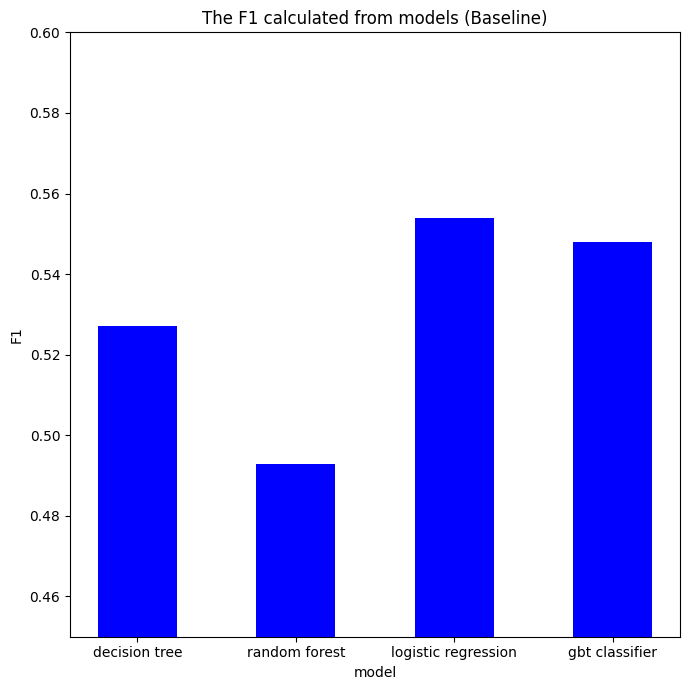

In [80]:
# Prepare the data
f1 = [dt_f1, rf_f1, lr_f1, gbt_f1]
model = ['decision tree', 'random forest', 'logistic regression', 'gbt classifier']
width = 0.5

# Plot the data
plt.figure(figsize = (7,7))
plt.bar(model, f1, width, align = 'center', color = 'blue')

plt.xticks(model)
plt.ylim(0.45, 0.6)
plt.xlabel('model')
plt.ylabel('F1')
plt.title('The F1 calculated from models (Baseline)')
plt.tight_layout()
plt.show()

# Downsampling

In machine learning, downsampling refers to a technique used to address the class imbalance problem by reducing the number of instances in the majority class. Class imbalance occurs when one class is significantly overrepresented compared to the others, making it challenging for the learning algorithm to generalize well to the minority class.

Downsampling involves randomly selecting a subset of instances from the majority class to match the count of the minority class. By reducing the number of majority class instances, downsampling helps to balance the dataset and mitigate biases towards the dominant class.

In [81]:
from sklearn.utils import resample
import pandas as pd
# setting up testing and training sets
df_train, df_test = dataset.randomSplit([.75,.25],seed=42)

X_train = df_train.drop('RainTomorrow_index')
y_train = df_train.RainTomorrow_index

X_test = df_test.drop('RainTomorrow_index')
y_test = df_test.RainTomorrow_index
# concatenate our training data back together
X = df_train.toPandas()

In [82]:
# separate minority and majority classes
not_rain = X[X.RainTomorrow_index==0]
rain = X[X.RainTomorrow_index==1]

In [83]:
# downsample majority
not_rain_downsampled = resample(not_rain,
                                replace = False, # sample without replacement
                                n_samples = len(rain), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_rain_downsampled, rain])

# checking counts
downsampled.RainTomorrow_index.value_counts()

0.0    23944
1.0    23944
Name: RainTomorrow_index, dtype: int64

In [84]:
train_downsampled = spark.createDataFrame(downsampled)

## Decision Tree

In [85]:
dt_down = DecisionTreeClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxDepth=20, maxBins = 120)
dt_down_model, dt_down_results = fit_model(dt_down , train_downsampled, df_test)

In [86]:
dt_confusion_down= get_confusion_matrix(dt_down_results)
dt_accuracy_down = evaluator.evaluate(dt_down_results)
_, _, dt_f1_down  =  calculate_rates(dt_confusion_down)

dt_confusion_down= get_confusion_matrix(dt_down_results)
print("The accuracy of the Decision Tree Classifier is %g " % (dt_accuracy_down))
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(dt_confusion_down)[i]))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The accuracy of the Decision Tree Classifier is 0.708352 
The Precision of the Decision Tree Classifier is 0.4035407256301909
The Recall of the Decision Tree Classifier is 0.6982226143955629
The F1 Score of the Decision Tree Classifier is 0.5114732905489635


## Random Forest

In [87]:
rf_down =  RandomForestClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", numTrees=20, maxDepth=20)
rf_down_model, rf_down_results = fit_model(rf_down , train_downsampled, df_test)

In [88]:
rf_confusion_down= get_confusion_matrix(rf_down_results)
rf_accuracy_down = evaluator.evaluate(rf_down_results)
_, _, rf_f1_down  =  calculate_rates(rf_confusion_down)

rf_confusion_down= get_confusion_matrix(rf_down_results)
# Calculate the rates from the confusion matrix
print("The accuracy of the Decision Tree Classifier is %g " % (rf_accuracy_down))
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(rf_confusion_down)[i]))

The accuracy of the Decision Tree Classifier is 0.784537 
The Precision of the Decision Tree Classifier is 0.5048293089092423
The Recall of the Decision Tree Classifier is 0.7642758099079793
The F1 Score of the Decision Tree Classifier is 0.6080328937471794


## Logistic Regression

In [89]:
lr_down = LogisticRegression(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10, regParam = 0.01, elasticNetParam = 0.001)
lr_down_model, lr_down_results = fit_model(lr_down , train_downsampled, df_test)

In [90]:
lr_confusion_down= get_confusion_matrix(lr_down_results)
lr_accuracy_down = evaluator.evaluate(lr_down_results)
_, _, lr_f1_down  =  calculate_rates(lr_confusion_down)

lr_confusion_down= get_confusion_matrix(lr_down_results)
print("The accuracy of the Decision Tree Classifier is %g " % (lr_accuracy_down))
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(lr_confusion_down)[i]))

The accuracy of the Decision Tree Classifier is 0.779217 
The Precision of the Decision Tree Classifier is 0.4967774336653553
The Recall of the Decision Tree Classifier is 0.7481406781797555
The F1 Score of the Decision Tree Classifier is 0.597082494969819


## GBT

In [91]:
gbt_down = GBTClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=20, maxDepth = 7)
gbt_down_model, gbt_down_results = fit_model(gbt_down , train_downsampled, df_test)

In [92]:
gbt_confusion_down= get_confusion_matrix(gbt_down_results)
gbt_accuracy_down = evaluator.evaluate(gbt_down_results)
_, _, gbt_f1_down  =  calculate_rates(gbt_confusion_down)

gbt_confusion_down= get_confusion_matrix(gbt_down_results)
print("The accuracy of the Decision Tree Classifier is %g " % (gbt_accuracy_down))
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(gbt_confusion_down)[i]))

The accuracy of the Decision Tree Classifier is 0.788837 
The Precision of the Decision Tree Classifier is 0.5117039586919105
The Recall of the Decision Tree Classifier is 0.7495272910626497
The F1 Score of the Decision Tree Classifier is 0.60819311614586


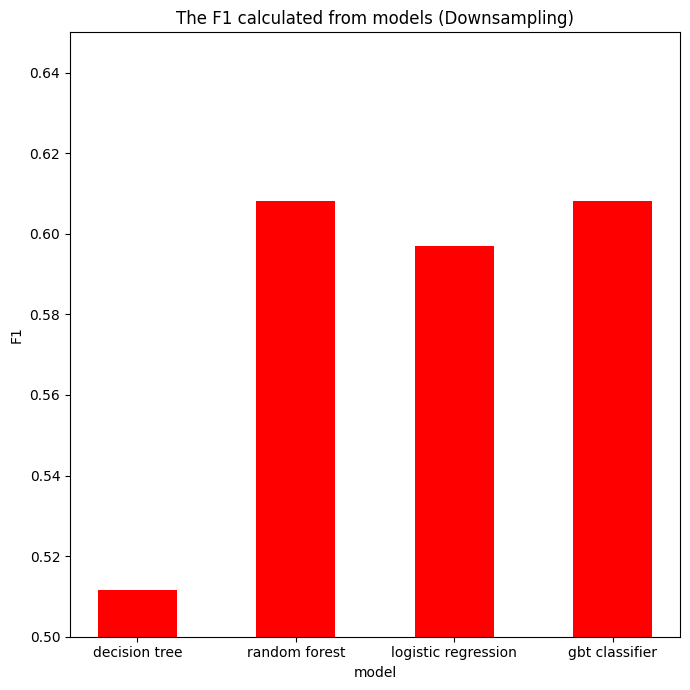

In [93]:
# Prepare the data
f1 = [dt_f1_down, rf_f1_down, lr_f1_down, gbt_f1_down]
model = ['decision tree', 'random forest', 'logistic regression', 'gbt classifier']
width = 0.5

# Plot the data
plt.figure(figsize = (7,7))
plt.bar(model, f1, width, align = 'center', color = 'red')

plt.xticks(model)
plt.ylim(0.5, 0.65)
plt.xlabel('model')
plt.ylabel('F1')
plt.title('The F1 calculated from models (Downsampling)')
plt.tight_layout()
plt.show()

# Upsampling

Upsampling is the inverse od downsampling; it refers to a technique used to address the class imbalance problem in a dataset. Class imbalance occurs when the number of instances belonging to different classes is not evenly distributed, with one class being significantly underrepresented compared to the others.

Upsampling involves increasing the number of instances in the minority class or classes to balance the dataset with the majority class. This technique aims to provide the learning algorithm with more examples of the minority class, allowing it to learn better and avoid biases towards the majority class. The process involves creating synthetic or replicated samples from the existing instances of the minority class.

In [94]:
# upsample majority
rain_upsampled = resample(rain,
                        replace = True, # sample with replacement
                        n_samples = len(not_rain), # match minority n
                        random_state = 42) # reproducible results

# combine minority and upsampled majority
upsampled = pd.concat([not_rain, rain_upsampled])

# checking counts
upsampled.RainTomorrow_index.value_counts()

0.0    85236
1.0    85236
Name: RainTomorrow_index, dtype: int64

In [95]:
train_upsampled = spark.createDataFrame(upsampled)

## Decision Tree

In [96]:
dt_up = DecisionTreeClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxDepth=20, maxBins = 120)
dt_up_model, dt_up_results = fit_model(dt_up , train_upsampled, df_test)

In [97]:
dt_confusion_up= get_confusion_matrix(dt_up_results)
dt_accuracy_up = evaluator.evaluate(dt_up_results)
_, _, dt_f1_up  =  calculate_rates(dt_confusion_up)

dt_confusion_up= get_confusion_matrix(dt_up_results)
print("The accuracy of the Decision Tree Classifier is %g " % (dt_accuracy_up))
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(dt_confusion_up)[i]))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The accuracy of the Decision Tree Classifier is 0.776323 
The Precision of the Decision Tree Classifier is 0.48932426091037073
The Recall of the Decision Tree Classifier is 0.5257783940501701
The F1 Score of the Decision Tree Classifier is 0.5068967612566081


## Random Forest

In [98]:
rf_up =  RandomForestClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", numTrees=20, maxDepth=20)
rf_up_model, rf_up_results = fit_model(rf_up , train_upsampled, df_test)

In [99]:
rf_confusion_up= get_confusion_matrix(rf_up_results)
rf_accuracy_up = evaluator.evaluate(rf_up_results)
_, _, rf_f1_up  =  calculate_rates(rf_confusion_up)

rf_confusion_up= get_confusion_matrix(rf_up_results)
# Calculate the rates from the confusion matrix
print("The accuracy of the Decision Tree Classifier is %g " % (rf_accuracy_up))
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(rf_confusion_up)[i]))

The accuracy of the Decision Tree Classifier is 0.837321 
The Precision of the Decision Tree Classifier is 0.6430080270384453
The Recall of the Decision Tree Classifier is 0.575570402117736
The F1 Score of the Decision Tree Classifier is 0.6074231741386192


## Logistic Regression

In [100]:
lr_up = LogisticRegression(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10, regParam = 0.01, elasticNetParam = 0.001)
lr_up_model, lr_up_results = fit_model(lr_up , train_upsampled, df_test)

In [101]:
lr_confusion_up= get_confusion_matrix(lr_up_results)
lr_accuracy_up = evaluator.evaluate(lr_up_results)
_, _, lr_f1_up  =  calculate_rates(lr_confusion_up)

lr_confusion_up= get_confusion_matrix(lr_up_results)
print("The accuracy of the Decision Tree Classifier is %g " % (lr_accuracy_up))
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(lr_confusion_up)[i]))

The accuracy of the Decision Tree Classifier is 0.777949 
The Precision of the Decision Tree Classifier is 0.4948848041254263
The Recall of the Decision Tree Classifier is 0.7500315139291567
The F1 Score of the Decision Tree Classifier is 0.5963118861495289


## GBT

In [102]:
gbt_up = GBTClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=20, maxDepth = 7)
gbt_up_model, gbt_up_results = fit_model(gbt_up , train_upsampled, df_test)

In [103]:
gbt_confusion_up= get_confusion_matrix(gbt_up_results)
gbt_accuracy_up = evaluator.evaluate(gbt_up_results)
_, _, gbt_f1_up  =  calculate_rates(gbt_confusion_up)

gbt_confusion_up= get_confusion_matrix(gbt_up_results)
print("The accuracy of the Decision Tree Classifier is %g " % (gbt_accuracy_up))
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(gbt_confusion_up)[i]))

The accuracy of the Decision Tree Classifier is 0.793247 
The Precision of the Decision Tree Classifier is 0.5188745193988116
The Recall of the Decision Tree Classifier is 0.7485188453296358
The F1 Score of the Decision Tree Classifier is 0.6128915724828405


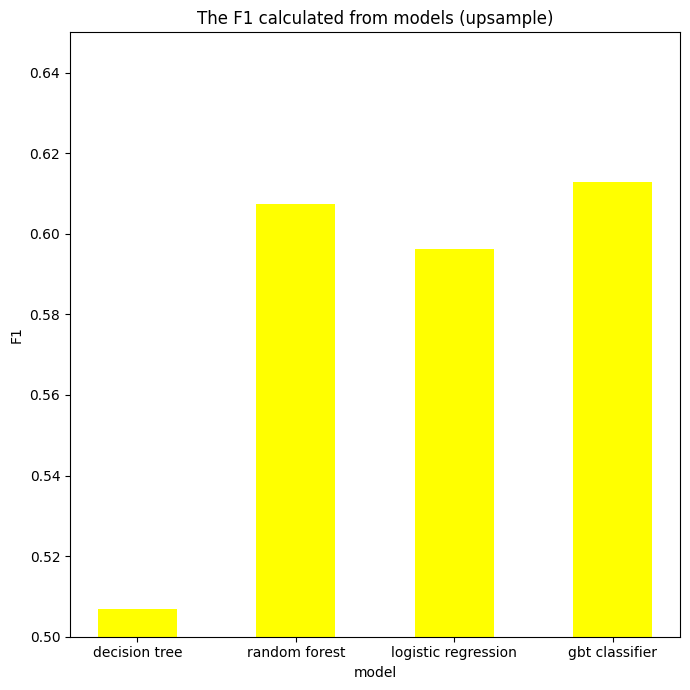

In [104]:
# Prepare the data
f1 = [dt_f1_up, rf_f1_up, lr_f1_up, gbt_f1_up]
model = ['decision tree', 'random forest', 'logistic regression', 'gbt classifier']
width = 0.5

# Plot the data
plt.figure(figsize = (7,7))
plt.bar(model, f1, width, align = 'center', color = 'yellow')

plt.xticks(model)
plt.ylim(0.5, 0.65)
plt.xlabel('model')
plt.ylabel('F1')
plt.title('The F1 calculated from models (upsample)')
plt.tight_layout()
plt.show()

# Reweighting

In machine learning, reweighting refers to a technique used to adjust the importance or emphasis given to different examples or features within a dataset. The goal of reweighting is to assign higher weights to certain examples or features, thereby influencing the learning algorithm to pay more attention to those instances during the training process.

In [105]:
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType

In [106]:
# Try weighted col since the cancelled outcome is unbalanced
balancingRatio = dataset.filter(col('RainTomorrow_index') == 1).count() / dataset.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

In [107]:
weightedDataset = dataset.withColumn("classWeightCol", calculateWeights('RainTomorrow_index'))
weightedDataset.groupby('classWeightCol').count().show()

+-------------------+------+
|     classWeightCol| count|
+-------------------+------+
| 0.7808538429808882| 31877|
|0.21914615701911178|113583|
+-------------------+------+



In [108]:
train_weight, test_weight = weightedDataset.randomSplit([0.75, 0.25], seed=42)

# Decision Tree


In [109]:
dt_weight = DecisionTreeClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxDepth=20, maxBins = 120)
dt_weight.setWeightCol('classWeightCol')
dtweightedmodel, dtweightedresults = fit_model(dt_weight, train_weight, test_weight)

In [110]:
dt_confusion_weight= get_confusion_matrix(dtweightedresults)
dt_accuracy = evaluator.evaluate(dtweightedresults)
print("The accuracy of the Decision Tree Classifier is %g " % (dt_accuracy))

_, _, dt_f1_w  =  calculate_rates(dt_confusion_weight)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(dt_confusion_weight)[i]))

The accuracy of the Decision Tree Classifier is 0.77048 
The Precision of the Decision Tree Classifier is 0.47818866253321524
The Recall of the Decision Tree Classifier is 0.544434640110929
The F1 Score of the Decision Tree Classifier is 0.5091659298555851


# Random Forest

In [111]:
rf_weight = RandomForestClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", numTrees=20, maxDepth=20)
rf_weight.setWeightCol('classWeightCol')
rfweightedmodel, rfweightedresults = fit_model(rf_weight, train_weight, test_weight)

In [112]:
rf_confusion_weight= get_confusion_matrix(rfweightedresults)
rf_accuracy = evaluator.evaluate(rfweightedresults)
print("The accuracy of the Decision Tree Classifier is %g " % (rf_accuracy))
_, _, rf_f1_w  =  calculate_rates(rf_confusion_weight)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(rf_confusion_weight)[i]))

The accuracy of the Decision Tree Classifier is 0.843743 
The Precision of the Decision Tree Classifier is 0.6920597217509331
The Recall of the Decision Tree Classifier is 0.5141812681205092
The F1 Score of the Decision Tree Classifier is 0.5900050625587618


# Logistic Regression

In [113]:
lr_weight = LogisticRegression(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=10, regParam = 0.01, elasticNetParam = 0.001)
lr_weight.setWeightCol('classWeightCol')
lrweightedmodel, lrweightedresults = fit_model(lr_weight, train_weight, test_weight)

In [114]:
lr_confusion_weight= get_confusion_matrix(lrweightedresults)
lr_accuracy = evaluator.evaluate(lrweightedresults)
print("The accuracy of the Decision Tree Classifier is %g " % (lr_accuracy))
_, _, lr_f1_w  =  calculate_rates(lr_confusion_weight)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(lr_confusion_weight)[i]))

The accuracy of the Decision Tree Classifier is 0.778859 
The Precision of the Decision Tree Classifier is 0.49624122953558303
The Recall of the Decision Tree Classifier is 0.7488970124795159
The F1 Score of the Decision Tree Classifier is 0.5969354433559407


# GBT

In [115]:
gbt_weight = GBTClassifier(labelCol= 'RainTomorrow_index', featuresCol= "FeatureVector", maxIter=20, maxDepth = 7)
gbt_weight.setWeightCol('classWeightCol')
gbtweightedmodel, gbtweightedresults = fit_model(gbt_weight, train_weight, test_weight)

In [116]:
gbt_confusion_weight= get_confusion_matrix(gbtweightedresults)
gbt_accuracy = evaluator.evaluate(gbtweightedresults)
print("The accuracy of the Decision Tree Classifier is %g " % (gbt_accuracy))
_, _, gbt_f1_w  =  calculate_rates(gbt_confusion_weight)
# Calculate the rates from the confusion matrix
for i in range(0,3):
    print('The {0} of the Decision Tree Classifier is {1}'.format(rates[i], calculate_rates(gbt_confusion_weight)[i]))

The accuracy of the Decision Tree Classifier is 0.790353 
The Precision of the Decision Tree Classifier is 0.5141033382213405
The Recall of the Decision Tree Classifier is 0.7512920710954242
The F1 Score of the Decision Tree Classifier is 0.6104680938236198


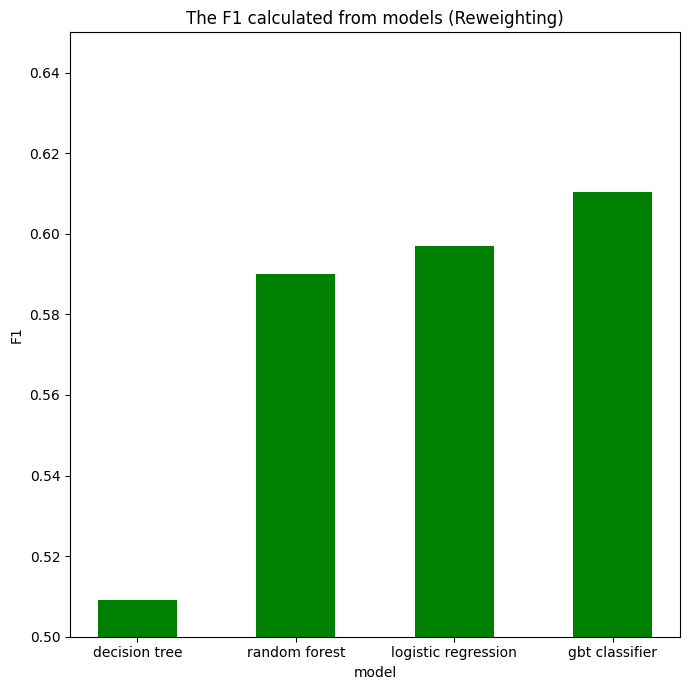

In [117]:
# Prepare the data
f1 = [dt_f1_w, rf_f1_w, lr_f1_w, gbt_f1_w]
model = ['decision tree', 'random forest', 'logistic regression', 'gbt classifier']
width = 0.5

# Plot the data
plt.figure(figsize = (7,7))
plt.bar(model, f1, width, align = 'center', color = 'green')

plt.xticks(model)
plt.ylim(0.5, 0.65)
plt.xlabel('model')
plt.ylabel('F1')
plt.title('The F1 calculated from models (Reweighting)')
plt.tight_layout()
plt.show()

## FINAL RESULTS

Overall the table below shows the final F1 results with al possible different model. As we can see, the GBT performed better than the others by reaching the maximun f1 score with the reweight. Also Random Forest perfromed very well after balancing of the classes. For Decision Tree and Logistic Regression the F1 do not increase consistently after balancing, it not guarantee improved performance in all cases.

In [118]:
# updating Final Results
final_results_pd = update_results_df(final_results_pd, 'Decision Tree', dt_f1, dt_f1_down, dt_f1_up, dt_f1_w)
final_results_pd = update_results_df(final_results_pd, 'Random Forest', rf_f1, rf_f1_down, rf_f1_up, rf_f1_w)
final_results_pd = update_results_df(final_results_pd, 'Logistic Regression', lr_f1, lr_f1_down, lr_f1_up, lr_f1_w)
final_results_pd = update_results_df(final_results_pd, 'GBT ', gbt_f1, gbt_f1_down, gbt_f1_up, gbt_f1_w)
final_results_pd

,Model,F1_Base,F1_Downsampling,F1_Upsampling,F1_Reweighting
0,Decision Tree,0.527006,0.511473,0.506897,0.509166
0,Random Forest,0.492776,0.608033,0.607423,0.590005
0,Logistic Regression,0.553936,0.597082,0.596312,0.596935
0,GBT,0.547994,0.608193,0.612892,0.610468


# Future improvements

The accuracy of the model can be improved by:

Using multiple imputation to place in missing values

1.   instead of mean values. The flaw of inputting mean values is that substituting the identical score for a large portion of the sample artificially decreases the variance of the variable , and makes the effect of missing data more profound when the percentage of missing data increases. Using multiple imputation will reduce the bias and increase accuracy.
2.   Adding more data. A larger data set allows better accuracy as you are able to train more data and obtain a more accurate output

3. Feature engineering: Create new features or transform existing ones to capture more meaningful information from the data. This may involve domain knowledge, mathematical transformations, scaling, binning, or creating interaction terms. Feature engineering can help the model discover relevant patterns and improve its predictive power.
